In [1]:
# Import packages
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
%run C:/Users/siebe/Documents/JT_Charts.ipynb

ps = PorterStemmer()
stopwords_english = set(stopwords.words('english'))

In [2]:
# Corpus
## US newspapers
Wall_Street_Journal = pd.read_csv('Wall Street Journal.csv')
Washington_post = pd.read_csv('Washington Post.csv')
New_York_Times = pd.read_csv('New York Times.csv')

def corpus_create(news, val):
    news = news.drop(['title'], axis=1)
    news = news.dropna(how='all')
    news['newspaper'] = val
    return news

Wall_Street_Journal = corpus_create(Wall_Street_Journal, 'Wall Street Journal')
Washington_post = corpus_create(Washington_post, 'Washington Post')
New_York_Times = corpus_create(New_York_Times, 'New York Times')

corpus=pd.concat([Wall_Street_Journal, New_York_Times, Washington_post],axis=0,ignore_index=True)

corpus.head()

,text,newspaper
0,[Financial Analysis and Commentary]\nPolitical...,Wall Street Journal
1,China appears to be making its long-expected m...,Wall Street Journal
2,[Financial Analysis and Commentary]\nIn his pu...,Wall Street Journal
3,The possibility that Beijing would call in its...,Wall Street Journal
4,Hong Kong -- President Xi Jinping wanted Tuesd...,Wall Street Journal


In [3]:
# Balance
corpus['newspaper'].value_counts()

Wall Street Journal    216
Washington Post        209
New York Times         127
Name: newspaper, dtype: int64

In [4]:
keywords = ["\'s", "china daily", "people daily", "xinhua", 
            "wall street journal", "new york times", "washington post",
           "editorial", "commentary"]

# Case removal, non-alpha removal, keyword removal, and stemming
corpus['text'] = corpus['text'].str.split()
corpus['text'] = corpus['text'].apply(lambda x: [re.sub(r'[^a-zA-Z]', "",y.lower()) for y in x])
corpus['text'] = corpus['text'].apply(lambda x: [y for y in x if y not in keywords])
corpus['text'] = corpus['text'].apply(lambda x: [ps.stem(y) for y in x])
corpus['text'] = corpus['text'].apply(lambda x: [' '.join(x)])
corpus['text'] = pd.Series(corpus['text']).astype(str)
corpus.head()

,text,newspaper
0,['financi analysi and polit unrest ha cast dou...,Wall Street Journal
1,['china appear to be make it longexpect move t...,Wall Street Journal
2,['financi analysi and in hi pursuit of the roa...,Wall Street Journal
3,['the possibl that beij would call in it armi ...,Wall Street Journal
4,['hong kong presid xi jinp want tuesday beij...,Wall Street Journal


In [5]:
# Split data

# Separate features and target
corpus_text = corpus.iloc[:,0]
corpus_classes = corpus.iloc[:,1]

# split the dataset into training and validation datasets 
x_train, x_test, y_train, y_test = train_test_split(corpus_text, corpus_classes, 
                                                    test_size=0.3, stratify=corpus_classes)
print(x_train.head())

51     ['in the end there wa no big octob surpris for...
79     ['beij  china confirm that mainland polic have...
245    ['i just didnt realiz it hong kong  first came...
403    ['australia new zealand reassess tie as beij b...
214    ['hong kong  polic arrest three promin opposit...
Name: text, dtype: object


In [6]:
# label encode the target variable 
labels = preprocessing.LabelEncoder()
y_train = labels.fit_transform(y_train)
y_test = labels.fit_transform(y_test)
labels.classes_

array(['New York Times', 'Wall Street Journal', 'Washington Post'],
      dtype=object)

# Create document term matrices
### Create binary DTM in which words present in doc receive value of one
### Create term frequency DTM to emphasize most commonly used words
### Create TF-IDF DTM to emphasize words most specific to each document

In [7]:
# Create Unigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1), binary=True) 
vectorizer.fit(x_train)
binary1_train = vectorizer.transform(x_train)
binary1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary1_train.toarray()) 

Count of terms 3981
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
# Create Bigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2), binary=True) 
vectorizer.fit(x_train)
binary2_train = vectorizer.transform(x_train)
binary2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary2_train.toarray()) 

Count of terms 7059
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
# Create Trigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3), binary=True) 
vectorizer.fit(x_train)
binary3_train = vectorizer.transform(x_train)
binary3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary3_train.toarray()) 

Count of terms 7858
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [10]:
# Create Unigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1)) 
vectorizer.fit(x_train)
tf1_train = vectorizer.transform(x_train)
tf1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf1_train.toarray()) 

Count of terms 3981
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
# Create Bigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2)) 
vectorizer.fit(x_train)
tf2_train = vectorizer.transform(x_train)
tf2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf2_train.toarray()) 

Count of terms 7059
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
# Create Trigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3)) 
vectorizer.fit(x_train)
tf3_train = vectorizer.transform(x_train)
tf3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf3_train.toarray()) 

Count of terms 7858
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# Create Unigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1))
vectorizer.fit(x_train)
tfidf1_train = vectorizer.transform(x_train)
tfidf1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf1_train.toarray()) 

Count of terms 3981
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.05307291 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
# Create Bigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2))
vectorizer.fit(x_train)
tfidf2_train = vectorizer.transform(x_train)
tfidf2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf2_train.toarray()) 

Count of terms 7059
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04912643 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [15]:
# Create Trigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3))
vectorizer.fit(x_train)
tfidf3_train = vectorizer.transform(x_train)
tfidf3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf3_train.toarray())

Count of terms 7858
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04799482 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Model nine configurations in a loop

In [16]:
# Define model training
def train_model(dtm, test):
    # model the training data
    clf.fit(dtm, y_train)
    
    # predictions on the test data
    preds = clf.predict(test)
    
    # print metrics
    print("Accuracy:", '{:1.4f}'.format(accuracy_score(y_test, preds)))
    print("")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    
    return '{:1.4f}'.format(accuracy_score(y_test, preds))

In [17]:
# Use Naive Bayes
clf = XGBClassifier() #MultinomialNB()

# Model Configurations
binary1 = ("unigram, binary", binary1_train, binary1_test)
binary2 = ("bigram, binary",  binary2_train, binary2_test)
binary3 = ("trigram, binary", binary3_train, binary3_test)
tf1 = ("unigram, TF", tf1_train, tf1_test)
tf2 = ("bigram, TF",  tf2_train, tf2_test)
tf3 = ("trigram, TF", tf3_train, tf3_test)
tfidf1 = ("unigram, TF-IDF", tfidf1_train, tfidf1_test)
tfidf2 = ("bigram, TF-IDF",  tfidf2_train, tfidf2_test)
tfidf3 = ("trigram, TF-IDF", tfidf3_train, tfidf3_test)
DTMs = [binary1, binary2, binary3,
        tf1, tf2, tf3,
        tfidf1, tfidf2, tfidf3]

df = pd.DataFrame({"config": [],
                   "accuracy": []})
best_config = ["Best Configuration", "none", 0, "none", "none"]
for data in DTMs:
    print(data[0])
    print("")
    score = train_model(data[1], data[2])
    print("======================================================")
    print("")
    if float(score) > float(best_config[2]):
        best_config = ["Best Configuration:", data[0], score, data[1], data[2]]
    df = df.append({"config": data[0],
               "accuracy": float(score)},
               ignore_index=True)

unigram, binary

Accuracy: 0.9880

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.98      0.98      0.98        65
           2       0.98      0.98      0.98        63

    accuracy                           0.99       166
   macro avg       0.99      0.99      0.99       166
weighted avg       0.99      0.99      0.99       166

Confusion Matrix:
[[38  0  0]
 [ 0 64  1]
 [ 0  1 62]]

bigram, binary

Accuracy: 0.9819

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.97      0.98      0.98        65
           2       0.98      0.97      0.98        63

    accuracy                           0.98       166
   macro avg       0.98      0.98      0.98       166
weighted avg       0.98      0.98      0.98       166

Confusion Matrix:
[[38  0  0]
 [ 0 64  1]
 [ 0  2 61]]

trigram, binary

Accuracy: 0.9819

              precisio

In [18]:
# Each model's result
df

,config,accuracy
0,"unigram, binary",0.9880
1,"bigram, binary",0.9819
2,"trigram, binary",0.9819
3,"unigram, TF",0.9819
4,"bigram, TF",0.9759
5,"trigram, TF",0.9819
6,"unigram, TF-IDF",0.9819
7,"bigram, TF-IDF",0.9819
8,"trigram, TF-IDF",0.9819


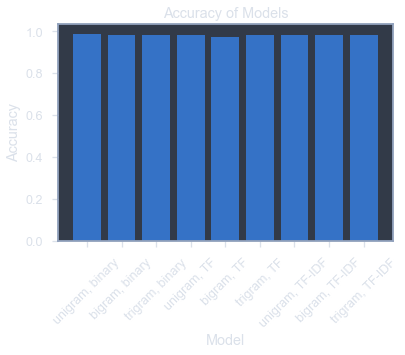

In [19]:
# Create plot
plt.figure()

# Create plot title
plt.title("Accuracy of Models")

# Add bars
plt.bar(range(df.shape[0]), df['accuracy'])
plt.yticks([0,.2,.4,.6,.8,1]) 
plt.ylabel('Accuracy')

# Add feature names as x-axis labels
plt.xticks(range(df.shape[0]), df['config'], rotation=45)
plt.xlabel('Model')

# Show plot
plt.show()

In [20]:
# Best Configuration
print(best_config)

['Best Configuration:', 'unigram, binary', '0.9880', <386x3981 sparse matrix of type '<class 'numpy.int64'>'
	with 109389 stored elements in Compressed Sparse Row format>, <166x3981 sparse matrix of type '<class 'numpy.int64'>'
	with 45225 stored elements in Compressed Sparse Row format>]


In [21]:
# Best Configuration
clf.fit(best_config[3], y_train)

# predictions on the test data
preds = clf.predict(best_config[4])

# feature importance
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [vectorizer.get_feature_names()[i] for i in indices]

In [22]:
# Main features
names[0:50]

['cancel flight',
 'canist tear ga',
 'extradit ha',
 'forefront',
 'compani china',
 'czech',
 'hong kong border',
 'date',
 'foreign forc',
 'capitul',
 'bigger',
 'includ independ',
 'blast',
 'fear beij',
 'democrat republican',
 'global time',
 'blaze',
 'involv',
 'crowdsourc',
 'expand',
 'amid grow',
 'death',
 'crippl',
 'earli',
 'inflict',
 'hong kong longer',
 'graduat',
 'doe mean',
 'hong kong hundr',
 'critic condit',
 'leader wa',
 'late month',
 'argument',
 'credit jillian',
 'erod',
 'freedom democraci',
 'jeremi',
 'english',
 'interview',
 'john hopkin',
 'forc beij',
 'broadcast',
 'coerc',
 'han',
 'kong becaus',
 'law order',
 'ha clear',
 'expos',
 'corrupt',
 'free elect']

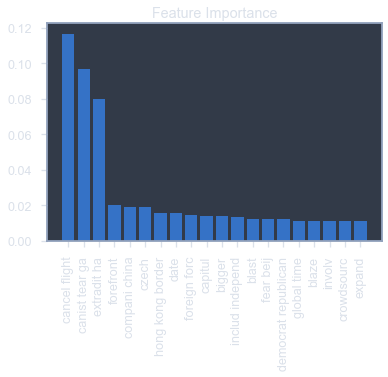

In [23]:
num_features = 20

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(num_features), importances[indices][0:num_features])

# Add feature names as x-axis labels
plt.xticks(range(num_features), names[0:num_features], rotation=90)

# Show plot
plt.show()